In [1]:
pip install torch torchvision timm wandb tqdm scikit-learn seaborn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorflow

2024-11-22 08:38:48.471827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 08:38:48.503303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732264728.544136   16657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732264728.555836   16657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 08:38:48.592893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 612 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 608s 14s/step - accuracy: 0.5769 - auc: 0.5135 - loss: 0.6857 - precision: 0.6068 - recall: 0.7805 - val_accuracy: 0.5879 - val_auc: 0.4842 - val_loss: 0.6786 - val_precision: 0.5879 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 548s 14s/step - accuracy: 0.5973 - auc: 0.5063 - loss: 0.6750 - precision: 0.5973 - recall: 1.0000 - val_accuracy: 0.5879 - val_auc: 0.4917 - val_loss: 0.6803 - val_precision: 0.5879 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 526s 13s/step - accuracy: 0.5969 - auc: 0.5053 - loss: 0.6771 - precision: 0.5967 - recall: 1.0000 - val_accuracy: 0.5879 - val_auc: 0.4745 - val_loss: 0.6814 - val_precision: 0.5879 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 546s 14s/step - accuracy: 0.5793 - auc: 0.4566 - loss: 0.6867 - precision: 0.5793 - recall: 1.0000 - val_accuracy: 0.5879 - val_auc: 0.4850 - val_loss: 0.6791 - val

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

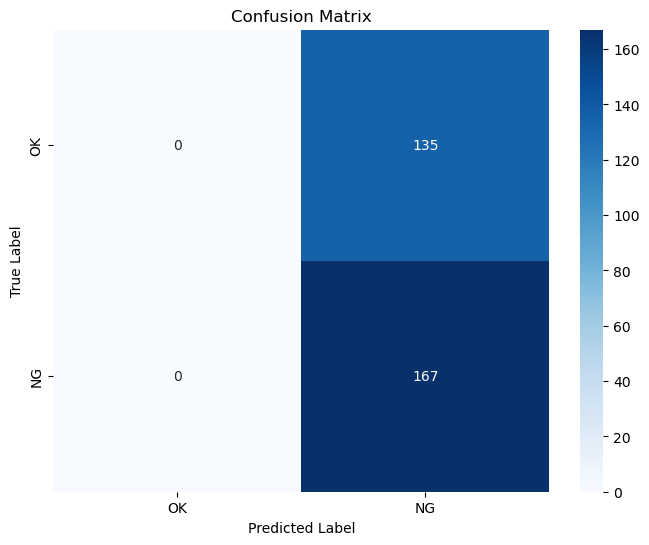

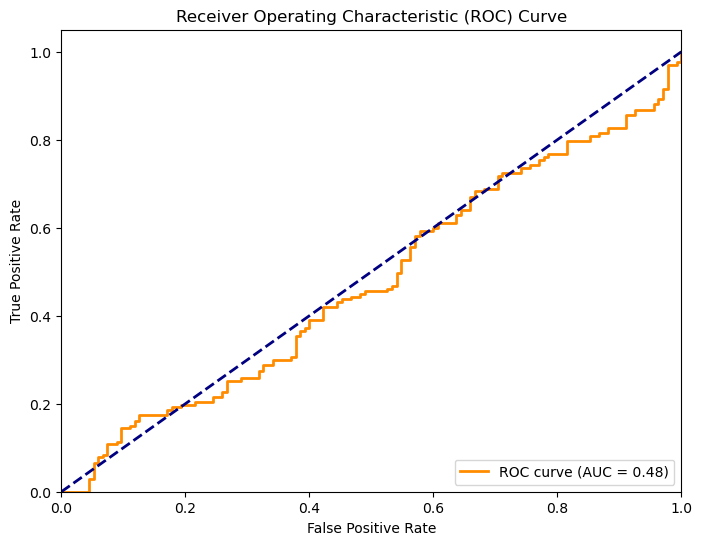

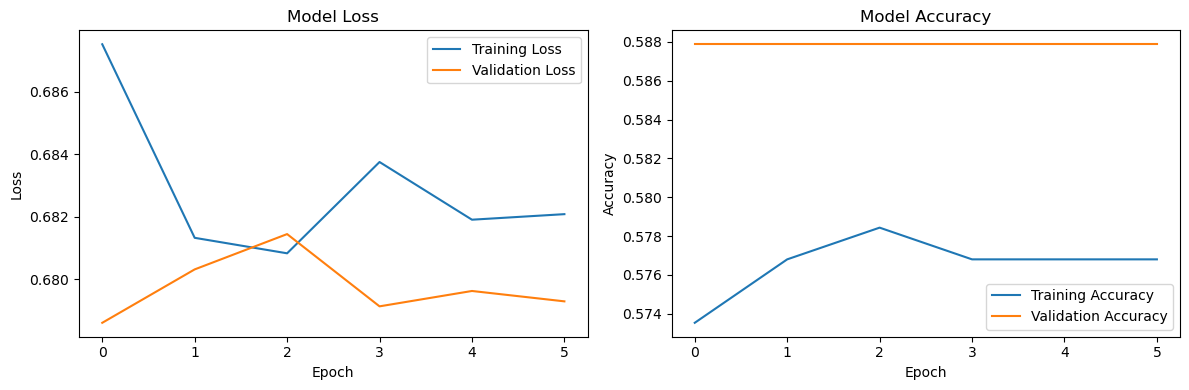

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

class DefectClassifier:
    def __init__(self, img_size=(480, 480), batch_size=16):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
    def create_model(self):
        """이진 분류를 위한 EfficientNetV2L 모델 생성"""
        base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
            include_top=False,
            weights='imagenet',
            input_shape=(*self.img_size, 3),
            pooling='avg'
        )
        # 전이학습을 위해 베이스 모델 동결
        base_model.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')  # 이진 분류를 위한 시그모이드 활성화
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()]
        )
        
        self.model = model
        return model
    
    def prepare_data(self, data_dir):
        """데이터 제너레이터 설정"""
        train_dir = os.path.join(data_dir, 'train')
        val_dir = os.path.join(data_dir, 'val')
        test_dir = os.path.join(data_dir, 'test')
        
        # 데이터 증강 설정
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # 검증 및 테스트 데이터는 증강하지 않음
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
        # 데이터 제너레이터 생성
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        valid_generator = valid_datagen.flow_from_directory(
            val_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        test_generator = valid_datagen.flow_from_directory(
            test_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        return train_generator, valid_generator, test_generator
    
    def train(self, train_generator, valid_generator, epochs=20):
        """모델 훈련"""
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',  # .h5 대신 .keras 사용
                monitor='val_accuracy',
                save_best_only=True
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3
            )
        ]

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator,
            callbacks=callbacks
        )

        return self.history
    
    def evaluate(self, test_generator):
        """모델 평가 및 다양한 지표 계산"""
        # 예측 수행
        predictions = self.model.predict(test_generator)
        y_pred = (predictions > 0.5).astype(int)
        y_true = test_generator.labels
        
        # 분류 보고서 출력
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['OK', 'NG']))
        
        # 혼동 행렬 시각화
        self.plot_confusion_matrix(y_true, y_pred)
        
        # ROC 커브 시각화
        self.plot_roc_curve(y_true, predictions)
        
        # 학습 곡선 시각화
        self.plot_learning_curves()
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """혼동 행렬 시각화"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['OK', 'NG'],
                   yticklabels=['OK', 'NG'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_roc_curve(self, y_true, y_pred_proba):
        """ROC 커브 시각화"""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_learning_curves(self):
        """학습 곡선 시각화"""
        plt.figure(figsize=(12, 4))
        
        # 손실 그래프
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 정확도 그래프
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    # 설정
    DATA_DIR = 'preprocessed_noise_contrast'  # 데이터 디렉토리 경로
    IMG_SIZE = (480, 480)
    BATCH_SIZE = 16
    EPOCHS = 20
    
    # 분류기 초기화 및 모델 생성
    classifier = DefectClassifier(img_size=IMG_SIZE, batch_size=BATCH_SIZE)
    model = classifier.create_model()
    
    # 데이터 준비
    train_generator, valid_generator, test_generator = classifier.prepare_data(DATA_DIR)
    
    # 모델 훈련
    history = classifier.train(train_generator, valid_generator, epochs=EPOCHS)
    
    # 모델 평가
    classifier.evaluate(test_generator)

if __name__ == "__main__":
    main()

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

class DefectClassifier:
    def __init__(self, img_size=(480, 480), batch_size=16):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
    def create_model(self):
        """이진 분류를 위한 EfficientNetV2M 모델 생성"""
        base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
            include_top=False,
            weights='imagenet',
            input_shape=(*self.img_size, 3),
            pooling='avg'
        )
        # 전이학습을 위해 베이스 모델 동결
        base_model.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')  # 이진 분류를 위한 시그모이드 활성화
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()]
        )
        
        self.model = model
        return model
    
    def prepare_data(self, data_dir):
        """데이터 제너레이터 설정"""
        train_dir = os.path.join(data_dir, 'train')
        val_dir = os.path.join(data_dir, 'val')
        test_dir = os.path.join(data_dir, 'test')
        
        # 데이터 증강 설정
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # 검증 및 테스트 데이터는 증강하지 않음
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
        # 데이터 제너레이터 생성
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        valid_generator = valid_datagen.flow_from_directory(
            val_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        test_generator = valid_datagen.flow_from_directory(
            test_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        return train_generator, valid_generator, test_generator
    
    def train(self, train_generator, valid_generator, epochs=20):
        """모델 훈련"""
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',  # .h5 대신 .keras 사용
                monitor='val_accuracy',
                save_best_only=True
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3
            )
        ]

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator,
            callbacks=callbacks
        )

        return self.history
    
    def evaluate(self, test_generator):
        """모델 평가 및 다양한 지표 계산"""
        # 예측 수행
        predictions = self.model.predict(test_generator)
        y_pred = (predictions > 0.5).astype(int)
        y_true = test_generator.labels
        
        # 분류 보고서 출력
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['OK', 'NG']))
        
        # 혼동 행렬 시각화
        self.plot_confusion_matrix(y_true, y_pred)
        
        # ROC 커브 시각화
        self.plot_roc_curve(y_true, predictions)
        
        # 학습 곡선 시각화
        self.plot_learning_curves()
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """혼동 행렬 시각화"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['OK', 'NG'],
                   yticklabels=['OK', 'NG'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_roc_curve(self, y_true, y_pred_proba):
        """ROC 커브 시각화"""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_learning_curves(self):
        """학습 곡선 시각화"""
        plt.figure(figsize=(12, 4))
        
        # 손실 그래프
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 정확도 그래프
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    # 설정
    DATA_DIR = 'preprocessed_noise_contrast'  # 데이터 디렉토리 경로
    IMG_SIZE = (480, 480)
    BATCH_SIZE = 16
    EPOCHS = 20
    
    # 분류기 초기화 및 모델 생성
    classifier = DefectClassifier(img_size=IMG_SIZE, batch_size=BATCH_SIZE)
    model = classifier.create_model()
    
    # 데이터 준비
    train_generator, valid_generator, test_generator = classifier.prepare_data(DATA_DIR)
    
    # 모델 훈련
    history = classifier.train(train_generator, valid_generator, epochs=EPOCHS)
    
    # 모델 평가
    classifier.evaluate(test_generator)

if __name__ == "__main__":
    main()

Found 612 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
Epoch 1/20


KeyboardInterrupt: 

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

class DefectClassifier:
    def __init__(self, img_size=(480, 480), batch_size=16):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
    def create_model(self):
        """이진 분류를 위한 EfficientNetV2L 모델 생성"""
        base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
            include_top=False,
            weights='imagenet',
            input_shape=(*self.img_size, 3),
            pooling='avg'
        )
        # 전이학습을 위해 베이스 모델 동결
        base_model.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')  # 이진 분류를 위한 시그모이드 활성화
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()]
        )
        
        self.model = model
        return model
    
    def prepare_data(self, data_dir):
        """데이터 제너레이터 설정"""
        train_dir = os.path.join(data_dir, 'train')
        val_dir = os.path.join(data_dir, 'val')
        test_dir = os.path.join(data_dir, 'test')
        
        # 데이터 증강 설정
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # 검증 및 테스트 데이터는 증강하지 않음
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
        # 데이터 제너레이터 생성
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        valid_generator = valid_datagen.flow_from_directory(
            val_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        test_generator = valid_datagen.flow_from_directory(
            test_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        return train_generator, valid_generator, test_generator
    
    def train(self, train_generator, valid_generator, epochs=20):
        """모델 훈련"""
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',  # .h5 대신 .keras 사용
                monitor='val_accuracy',
                save_best_only=True
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3
            )
        ]

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator,
            callbacks=callbacks
        )

        return self.history
    
    def evaluate(self, test_generator):
        """모델 평가 및 다양한 지표 계산"""
        # 예측 수행
        predictions = self.model.predict(test_generator)
        y_pred = (predictions > 0.5).astype(int)
        y_true = test_generator.labels
        
        # **정확도 계산**
        correct_predictions = np.sum(y_pred.flatten() == y_true)
        accuracy = correct_predictions / len(y_true)
        print(f"\nTest Accuracy: {accuracy:.2%}")  # 정확도를 퍼센트로 출력
        
        # 분류 보고서 출력
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['OK', 'NG']))
        
        # 혼동 행렬 시각화
        self.plot_confusion_matrix(y_true, y_pred)
        
        # ROC 커브 시각화
        self.plot_roc_curve(y_true, predictions)
        
        # 학습 곡선 시각화
        self.plot_learning_curves()
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """혼동 행렬 시각화"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['OK', 'NG'],
                   yticklabels=['OK', 'NG'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_roc_curve(self, y_true, y_pred_proba):
        """ROC 커브 시각화"""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_learning_curves(self):
        """학습 곡선 시각화"""
        plt.figure(figsize=(12, 4))
        
        # 손실 그래프
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 정확도 그래프
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [ ]:
def main():
    # 설정
    DATA_DIR = 'preprocessed_noise_contrast'  # 데이터 디렉토리 경로
    IMG_SIZE = (480, 480)
    BATCH_SIZE = 32
    EPOCHS = 15
    
    # 분류기 초기화 및 모델 생성
    classifier = DefectClassifier(img_size=IMG_SIZE, batch_size=BATCH_SIZE)
    model = classifier.create_model()
    
    # 데이터 준비
    train_generator, valid_generator, test_generator = classifier.prepare_data(DATA_DIR)
    
    # 모델 훈련
    history = classifier.train(train_generator, valid_generator, epochs=EPOCHS)
    
    # 모델 평가
    classifier.evaluate(test_generator)

if __name__ == "__main__":
    main()

Found 612 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 574s 24s/step - accuracy: 0.5389 - auc_3: 0.4790 - loss: 0.6903 - precision_3: 0.5552 - recall_3: 0.7956 - val_accuracy: 0.5879 - val_auc_3: 0.5226 - val_loss: 0.6778 - val_precision_3: 0.5879 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 610s 31s/step - accuracy: 0.5747 - auc_3: 0.4925 - loss: 0.6845 - precision_3: 0.5747 - recall_3: 1.0000 - val_accuracy: 0.5879 - val_auc_3: 0.5455 - val_loss: 0.6800 - val_precision_3: 0.5879 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 610s 30s/step - accuracy: 0.5776 - auc_3: 0.5504 - loss: 0.6797 - precision_3: 0.5776 - recall_3: 1.0000 - val_accuracy: 0.5879 - val_auc_3: 0.5386 - val_loss: 0.6770 - val_precision_3: 0.5879 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 643s 